In this notebook, we make a few plots of detected ligand receptor genes in EOMESpos/HOPXpos AOIs:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import scipy as sp
import pickle as pickle
import scipy as sc
import matplotlib
import matplotlib.colors as colors
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [5]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']
adata.layers['Stabilized'] = NaiveDE.stabilize(adata.layers['X_Corrected_V2'])
adata.obs['TotalCounts'] = np.sum(adata.layers['X_Corrected_V2'], axis = 1)
adata.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized'].T, 'np.log(TotalCounts)').T

Define the genes we are interested in:

In [6]:
receptors = np.array(('LIFR', 'IL6ST', 'PTPRZ1', 'ITGB5', 'HS6ST1', 'SDC3', 'FGFR1', 'FGFR2','FGFR3'))
ligands = np.array(('LIF', 'TNC', 'PTN', 'FGF1', 'FGF2', 'FGF3', 'FGF4', 'FGF5', 'FGF6', 'FGF7', 'FGF8', 'FGF9', 'FGF10'))
receptors_index = [np.where(adata.var_names == receptors[i])[0][0] for i in range(len(receptors))]
ligands_index = [np.where(adata.var_names == ligands[i])[0][0] for i in range(len(ligands))]

Choose HOPXpos AOIs:

In [7]:
subset = [adata.obs['AOI_type'][i] == 'HOPXpos' and adata.obs['age'][i] == '19pcw' for i in range(len(adata.obs['AOI_type']))]
meanExpression = np.mean(np.log2(adata.layers['CPM_corrected_V2'][subset,:]), axis = 0)
meanExpression = pd.DataFrame(index = adata.var_names, columns = ['HOPXpos'], data=meanExpression)
subset = [adata.obs['AOI_type'][i] != 'HOPXpos' and adata.obs['age'][i] == '19pcw'
          and adata.obs['VCDepth'][i] <= 0.5 for i in range(len(adata.obs['AOI_type']))]
meanExpression2 = np.mean(np.log2(adata.layers['CPM_corrected_V2'][subset,:]), axis = 0)
meanExpression2 = pd.DataFrame(index = adata.var_names, columns = ['Background'], data=meanExpression2)

Show their expression in a heatmap:

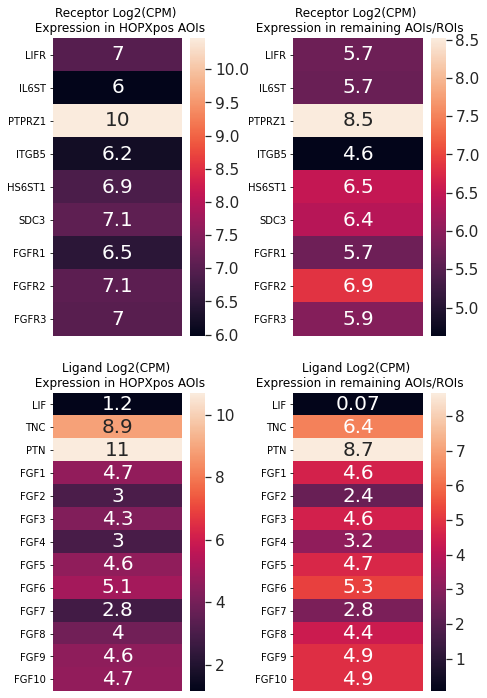

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (7,10))

sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression.loc[receptors,:],2), annot = True,  annot_kws={"size": 20},
            ax = ax1, xticklabels=False)
ax1.set_title('Receptor Log2(CPM) \n Expression in HOPXpos AOIs', fontsize=12)

sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression2.loc[receptors,:],2), annot = True,  annot_kws={"size": 20},
            ax = ax2, xticklabels=False)
plt.yticks(rotation=0)
ax2.set_title('Receptor Log2(CPM) \n Expression in remaining AOIs/ROIs', fontsize=12)

sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression.loc[ligands,:],2), annot = True,  annot_kws={"size": 20},
            ax = ax3, xticklabels=False)
ax3.set_title('Ligand Log2(CPM) \n Expression in HOPXpos AOIs', fontsize=12)

sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression2.loc[ligands,:],2), annot = True,  annot_kws={"size": 20},
            ax = ax4, xticklabels=False)
plt.yticks(rotation=0)
ax4.set_title('Ligand Log2(CPM) \n Expression in remaining AOIs/ROIs', fontsize=12)

plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure4F_ManualSelection_ReceptorLigandsHeatmap.pdf', bbox_inches='tight')
plt.show()

Slightly different plot of the same thing:

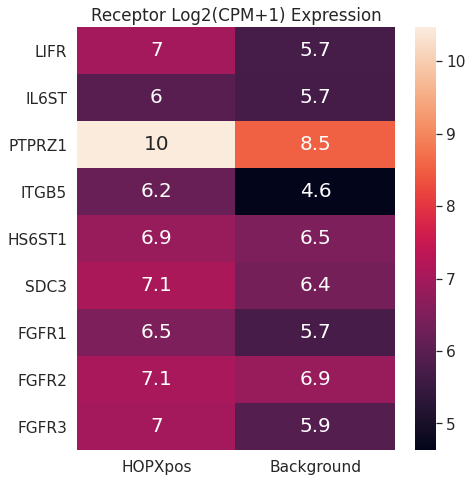

In [9]:
fig, ax = plt.subplots(1,1, figsize = (7,7))

sns.set(font_scale=1.4)
sns.heatmap(np.round(pd.concat([meanExpression.loc[receptors,:], meanExpression2.loc[receptors,:]], axis = 1),2), annot = True,  annot_kws={"size": 20},
            ax = ax, xticklabels=True)
ax.set_title('Receptor Log2(CPM+1) Expression')

plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Figure4F_ManualSelection_ReceptorsHeatmap.pdf', bbox_inches='tight')
plt.show()

The next plot shows an unbiased selection of receptor ligand pairs based on their spatial variation:

In [10]:
input_data = pickle.load(open( "../KR_NAS/data/ROI_relations.p", "rb" ))
input_data = input_data.loc[input_data['Slide'] != '00MW']
input_data

Slide  Radial_position   VCDepth Background HOPXpos EOMESpos ParallelROI  \
0   00MU                1  0.028892        126     111      103         107   
1   00MU                1  0.094703        156     141      134         122   
2   00MU                1  0.205457         96     172      164         137   
3   00MU                1  0.303371        127     112      104         152   
4   00MU                1  0.382022        157     142      135         160   
5   00MU                3  0.028892         94     170      162         107   
6   00MU                3  0.094703        125     110      102         122   
7   00MU                3  0.205457        155     140      133         137   
8   00MU                3  0.303371         95     171      163         152   
9   00MU                3  0.382022         97     173      165         160   
10  00MV                1  0.312557         35      21       13          98   
11  00MV                1  0.392513         67      51       43         106   
12  00MV                3  0.028457         36      22       14         143   
13  00MV                3  0.101036          6      81       74         158   
14  00MV                3  0.213702         68      52       44         174   
15  00MV                3  0.312557        190      82       75          98   

   Ring  
0   118  
1   148  
2   180  
3   119  
4   149  
5   178  
6   117  
7   147  
8   179  
9   181  
10   28  
11   59  
12   29  
13   89  
14   60  
15   90

In [11]:
input_data = input_data.loc[input_data['Slide'] == '00MU']
input_data

Slide  Radial_position   VCDepth Background HOPXpos EOMESpos ParallelROI  \
0  00MU                1  0.028892        126     111      103         107   
1  00MU                1  0.094703        156     141      134         122   
2  00MU                1  0.205457         96     172      164         137   
3  00MU                1  0.303371        127     112      104         152   
4  00MU                1  0.382022        157     142      135         160   
5  00MU                3  0.028892         94     170      162         107   
6  00MU                3  0.094703        125     110      102         122   
7  00MU                3  0.205457        155     140      133         137   
8  00MU                3  0.303371         95     171      163         152   
9  00MU                3  0.382022         97     173      165         160   

  Ring  
0  118  
1  148  
2  180  
3  119  
4  149  
5  178  
6  117  
7  147  
8  179  
9  181

In [12]:
x_coordinate = input_data.loc[:,'VCDepth']
adata_background = adata[list(input_data['Background']),:]
adata_AOIs = list((adata[list(input_data['HOPXpos']),:], adata[list(input_data['EOMESpos']),:]))

In [13]:
resultsList = list()
for target_index in range(2):
    print(target_index)
    nontarget_index = (1,0)[target_index]

    ### Load CellPhoneDB data:

    genes = pd.read_csv('../data/CellPhoneDB/gene_input.csv')
    proteins = pd.read_csv('../data/CellPhoneDB/protein_input.csv')
    interactions = pd.read_csv('../data/CellPhoneDB/interaction_input.csv')
    complexes = pd.read_csv('../data/CellPhoneDB/complex_input.csv')

    ### Remove duplicate protein names (probably due to different gene names for same protein in Ensemble)

    genes = genes.drop_duplicates(subset = 'uniprot')
    genes.index = genes['uniprot']
    proteins = pd.read_csv('../data/CellPhoneDB/protein_input.csv')
    proteins = proteins.drop_duplicates(subset = 'uniprot')
    genes = genes.reindex(np.array(proteins['uniprot']))

    ### Find receptors detected in each group of AOIs:

    genes_ligand = genes['gene_name'].iloc[np.invert(np.array(proteins['receptor']))]
    genes_receptor = genes['gene_name'].iloc[np.array(proteins['receptor'])]
    genes_receptor = genes_receptor[[genes_receptor[i] in adata.var_names for i in range(len(genes_receptor))]]
    detection_rate = np.array([[(adata_AOIs[target_index].X[j,adata_AOIs[target_index].var_names == genes_receptor[i]] >
                        adata_AOIs[target_index].obs['GeoLOD2.5_01'].iloc[j])[0] 
                        for j in range(np.shape(adata_AOIs[target_index])[0])] for i in range(len(genes_receptor))])
    keep_receptors = [sum(detection_rate[i,:]) > 2 for i in range(np.shape(detection_rate)[0])]
    genes_receptor = genes_receptor[keep_receptors]
    proteins_receptor = np.array([genes.index[np.where(genes['gene_name'] == genes_receptor[i])][0]
                        for i in range(len(genes_receptor))])

    ### Get the ligands for these receptors:

    proteins_ligand = np.repeat('EmptyEmptyEmptyEmptyEmpty', len(proteins_receptor))
    for i in range(len(proteins_ligand)):
        if sum(interactions['partner_a'] == proteins_receptor[i]) > 0:
            proteins_ligand[i] = interactions['partner_b'].loc[interactions['partner_a'] == proteins_receptor[i]].iloc[0]
        if sum(interactions['partner_b'] == proteins_receptor[i]) > 0:
            proteins_ligand[i] = interactions['partner_a'].loc[interactions['partner_b'] == proteins_receptor[i]].iloc[0]
    subset = [proteins_ligand[i] != 'EmptyEmptyEmptyEmptyEmpty' and proteins_ligand[i] not in list(complexes['complex_name'])
             for i in range(len(proteins_ligand))]
    proteins_receptor = proteins_receptor[subset]
    proteins_ligand = proteins_ligand[subset]

    genes_receptor = [np.array(genes['gene_name'])[np.array(genes['uniprot'] == proteins_receptor[i])][0] for i in range(len(proteins_receptor))]

    genes_ligand_old = [np.array(genes['gene_name'])[np.array(genes['uniprot'] == proteins_ligand[i])][0] for i in range(len(proteins_ligand))]
    gene_ligand_Index = np.where([adata.var_names[i] in genes_ligand_old
                                  for i in range(len(adata.var_names))])[0]
    genes_ligand = adata.var_names[gene_ligand_Index]
    
    counts_Background = np.array([(adata_background.layers['X'][i,:] + adata_AOIs[nontarget_index].layers['X'][i,:])
                                    for i in range(np.shape(adata_background.layers['X'])[0])])
    
    # Find spatially varying ligands:
    
    adata_subset = adata[list(input_data['EOMESpos']),:]
    adata_subset.obs['TotalCounts_Background'] = np.array([sum(adata_background.layers['X'][i,:] + adata_AOIs[nontarget_index].layers['X'][i,:])
        for i in range(np.shape(adata_background.layers['X'])[0])])
    adata_subset.layers['Counts_Background'] = counts_Background
    adata_subset.layers['StabilizedCounts_Background'] = NaiveDE.stabilize(counts_Background)
    adata_subset.layers['RegressedCounts_Backgound'] = NaiveDE.regress_out(adata_subset.obs, adata_subset.layers['StabilizedCounts_Background'].T, 'roi_dimension').T
    input_counts = pd.DataFrame(adata_subset.layers['RegressedCounts_Backgound'], index = adata_subset.obs['Sanger_sampleID'],
                   columns = adata_subset.var_names)
    input_coordinates = adata_subset.obs.loc[:,('Radial_position', 'VCDepth')].rename(columns={"Radial_position": "x", "VCDepth": "y"})
    results = SpatialDE.run(input_coordinates, input_counts.loc[:,genes_ligand])
    results['FDR'] = multi.multipletests(results['pval'], method = 'fdr_bh')[1]
    results['Receptors'] = [genes_receptor[np.where(np.array(genes_ligand_old) == g)[0][0]] for g in results['g']]
    results = results.sort_values('pval')
    resultsList.append(results.iloc[0:26,:]) #results['pval'] <= 0.1

0


Trying to set attribute `.obs` of view, copying.



1


Trying to set attribute `.obs` of view, copying.


In [14]:
topLigands = [np.array(resultsList[i].sort_values('pval')['g']) for i in range(2)]
print(topLigands)
topReceptors = [np.array(resultsList[i].sort_values('pval')['Receptors']) for i in range(2)]
print(topReceptors)

[array(['ERBB4', 'FGFR1', 'EFNB2', 'MDK', 'VEGFA', 'MIF', 'FGFR2', 'CCL21',
       'CORT', 'BMP7', 'COPA', 'PLXNB2', 'INS', 'VEGFB', 'DLL1', 'EPO',
       'FGF6', 'FAM3C', 'EFNA2', 'DLK1', 'EFNB3', 'CD72', 'INHBE',
       'PROS1', 'WNT5A', 'PDGFB'], dtype=object), array(['ERBB4', 'CRH', 'PTN', 'FGFR1', 'MDK', 'FGFR2', 'CCL21', 'DLL1',
       'EREG', 'IFNA8', 'WNT1', 'COPA', 'INS', 'EPO', 'CSF1', 'CD70',
       'WNT5A', 'DLK1', 'VEGFB', 'INHBC', 'CORT', 'INHBE', 'PLXNB2',
       'VEGFA', 'FAM3C', 'EFNA1'], dtype=object)]
[array(['HBEGF', 'NCAM1', 'EPHB1', 'LRP1', 'EPHB2', 'TNFRSF10D', 'XPR1',
       'CCR7', 'SSTR4', 'PTPRK', 'SORT1', 'SEMA4C', 'INSR', 'NRP1',
       'NOTCH2', 'EFNB2', 'FGFR1', 'HLA-C', 'EPHA7', 'NOTCH3', 'EPHB6',
       'SEMA4D', 'ACVR2A', 'AXL', 'FZD3', 'PDGFRB'], dtype=object), array(['HBEGF', 'CRHR2', 'PTPRS', 'NCAM1', 'LRP1', 'XPR1', 'CCR7',
       'NOTCH2', 'EGFR', 'GPR152', 'RYK', 'SORT1', 'INSR', 'EFNB2',
       'CELSR3', 'CD27', 'FZD3', 'NOTCH3', 'NRP1', 'ACVR2B

In [15]:
# Don't show ERBB4, HBEGF interaction
topLigands = [np.flipud(topLigands[i][topLigands[i] != 'ERBB4']) for i in range(2)]
topReceptors = [np.flipud(topReceptors[i][topReceptors[i] != 'HBEGF']) for i in range(2)]

In [16]:
resultsList[0].to_csv('../KR_NAS/0_publication_tables/spatiallyVaryingLigands_IP.csv')
resultsList[1].to_csv('../KR_NAS/0_publication_tables/spatiallyVaryingLigands_oRG.csv')

Now make a simple plot with spatially varying receptor ligand pairs in HOPXpos and EOMESpos AOIs and background:

In [17]:
input_data = input_data.loc[input_data['Slide'] == '00MU']
input_data

Slide  Radial_position   VCDepth Background HOPXpos EOMESpos ParallelROI  \
0  00MU                1  0.028892        126     111      103         107   
1  00MU                1  0.094703        156     141      134         122   
2  00MU                1  0.205457         96     172      164         137   
3  00MU                1  0.303371        127     112      104         152   
4  00MU                1  0.382022        157     142      135         160   
5  00MU                3  0.028892         94     170      162         107   
6  00MU                3  0.094703        125     110      102         122   
7  00MU                3  0.205457        155     140      133         137   
8  00MU                3  0.303371         95     171      163         152   
9  00MU                3  0.382022         97     173      165         160   

  Ring  
0  118  
1  148  
2  180  
3  119  
4  149  
5  178  
6  117  
7  147  
8  179  
9  181

In [18]:
x_coordinate = input_data.loc[:,'VCDepth']
adata_background = adata[list(input_data['Background']),:]
adata_AOIs = list((adata[list(input_data['HOPXpos']),:], adata[list(input_data['EOMESpos']),:]))

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


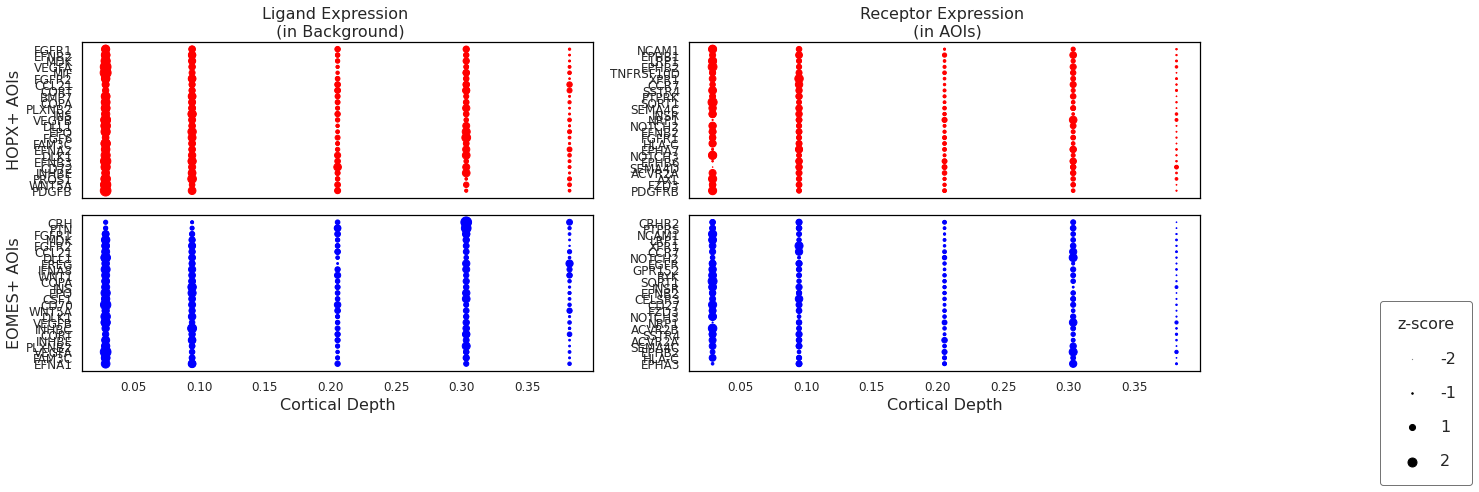

In [19]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 1
power = 3

fig, ax = plt.subplots(2,2,figsize = (21,7), sharex = True)

# HOPXpos AOIs:
target_index = 0
nontarget_index = (1,0)[target_index]
normCounts_AOI = sc.stats.zscore(np.log2(np.array([adata_AOIs[target_index].layers['X_Corrected_V2'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X_Corrected_V2'])[0])])*10**6 + 1), axis = 0)

normCounts_Background = sc.stats.zscore(np.log2(np.array([(adata_background.layers['X_Corrected_V2'][i,:] + adata_AOIs[nontarget_index].layers['X_Corrected_V2'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X_Corrected_V2'])[0])])*10**6 + 1), axis = 0)

# Ligands:
genesForPlot = np.repeat(topLigands[0],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topLigands[0]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topLigands[0]])

ax[0,0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0,0].set_ylabel('HOPX+ AOIs')
ax[0,0].set_title('Ligand Expression \n (in Background)')
ax[0,0].set_facecolor('w')

# Receptors:
genesForPlot = np.repeat(topReceptors[0],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topReceptors[0]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topReceptors[0]])

ax[0,1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0,1].set_title('Receptor Expression \n (in AOIs)')
ax[0,1].set_facecolor('w')

# EOMESpos AOIs:
target_index = 1
nontarget_index = (1,0)[target_index]
normCounts_AOI = sc.stats.zscore(np.log2(np.array([adata_AOIs[target_index].layers['X_Corrected_V2'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X_Corrected_V2'])[0])])*10**6 + 1), axis = 0)

normCounts_Background = sc.stats.zscore(np.log2(np.array([(adata_background.layers['X_Corrected_V2'][i,:] + adata_AOIs[nontarget_index].layers['X_Corrected_V2'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X_Corrected_V2'])[0])])*10**6 + 1), axis = 0)

# Ligands:
genesForPlot = np.repeat(topLigands[1],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topLigands[1]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topLigands[1]])

ax[1,0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'blue')
ax[1,0].set_xlabel('Cortical Depth')
ax[1,0].set_ylabel('EOMES+ AOIs')
ax[1,0].set_facecolor('w')

# Receptors:
genesForPlot = np.repeat(topReceptors[1],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topReceptors[1]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topReceptors[1]])

ax[1,1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'blue')
ax[1,1].set_xlabel('Cortical Depth')
ax[1,1].set_facecolor('w')

# Make a legend:
pws = [0,-2,-1,1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/Figure4G_ReceptorLigand_UnbiasedSelection_AreaNormalized_z-score.pdf',
            bbox_inches='tight')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


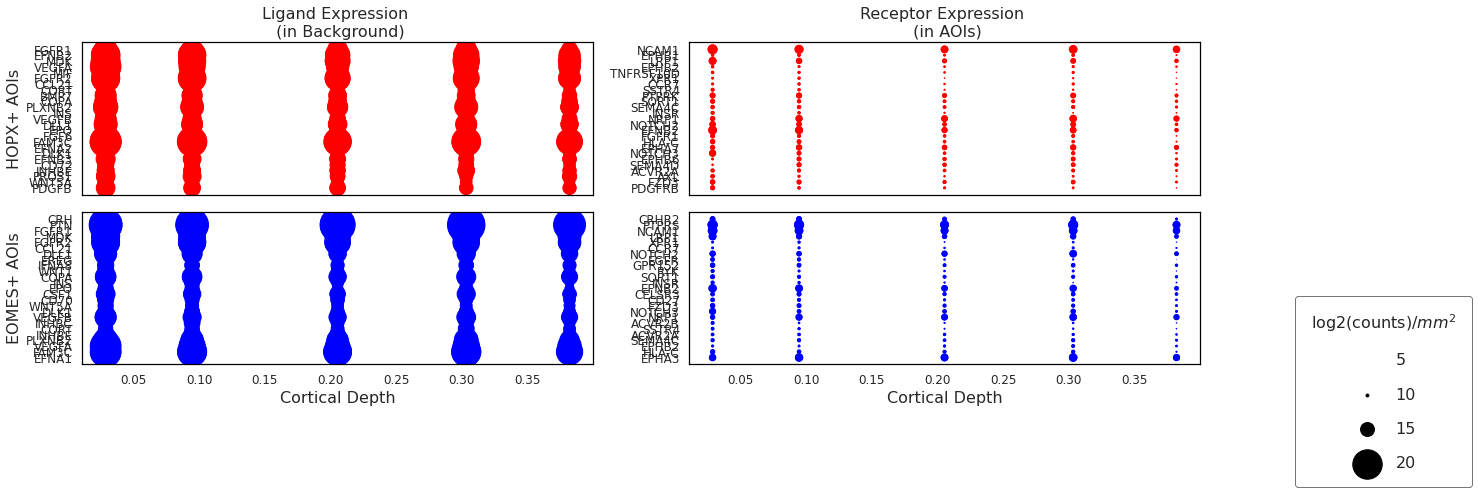

In [20]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 0.75
power = 3

fig, ax = plt.subplots(2,2,figsize = (21,7), sharex = True)

# HOPXpos AOIs:
target_index = 0
nontarget_index = (1,0)[target_index]
normCounts_AOI = np.log2(np.array([adata_AOIs[target_index].layers['X_Corrected_V2'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X_Corrected_V2'])[0])])*10**6 + 1)

normCounts_Background = np.log2(np.array([(adata_background.layers['X_Corrected_V2'][i,:] + adata_AOIs[nontarget_index].layers['X_Corrected_V2'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X_Corrected_V2'])[0])])*10**6 + 1)

# Ligands:
genesForPlot = np.repeat(topLigands[0],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topLigands[0]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topLigands[0]])

ax[0,0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0,0].set_ylabel('HOPX+ AOIs')
ax[0,0].set_title('Ligand Expression \n (in Background)')
ax[0,0].set_facecolor('w')

# Receptors:
genesForPlot = np.repeat(topReceptors[0],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topReceptors[0]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topReceptors[0]])

ax[0,1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0,1].set_title('Receptor Expression \n (in AOIs)')
ax[0,1].set_facecolor('w')

# EOMESpos AOIs:
target_index = 1
nontarget_index = (1,0)[target_index]
normCounts_AOI = np.log2(np.array([adata_AOIs[target_index].layers['X_Corrected_V2'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X'])[0])])*10**6 + 1)

normCounts_Background = np.log2(np.array([(adata_background.layers['X_Corrected_V2'][i,:] + adata_AOIs[nontarget_index].layers['X_Corrected_V2'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X_Corrected_V2'])[0])])*10**6 + 1)

# Ligands:
genesForPlot = np.repeat(topLigands[1],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topLigands[1]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topLigands[1]])

ax[1,0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'blue')
ax[1,0].set_xlabel('Cortical Depth')
ax[1,0].set_ylabel('EOMES+ AOIs')
ax[1,0].set_facecolor('w')

# Receptors:
genesForPlot = np.repeat(topReceptors[1],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topReceptors[1]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topReceptors[1]])

ax[1,1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'blue')
ax[1,1].set_xlabel('Cortical Depth')
ax[1,1].set_facecolor('w')

# Make a legend:
pws = [0,5,10,15,20]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="log2(counts)/$mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/Figure4G_ReceptorLigand_UnbiasedSelection_areaNormalized_log2Counts.pdf',
            bbox_inches='tight')

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


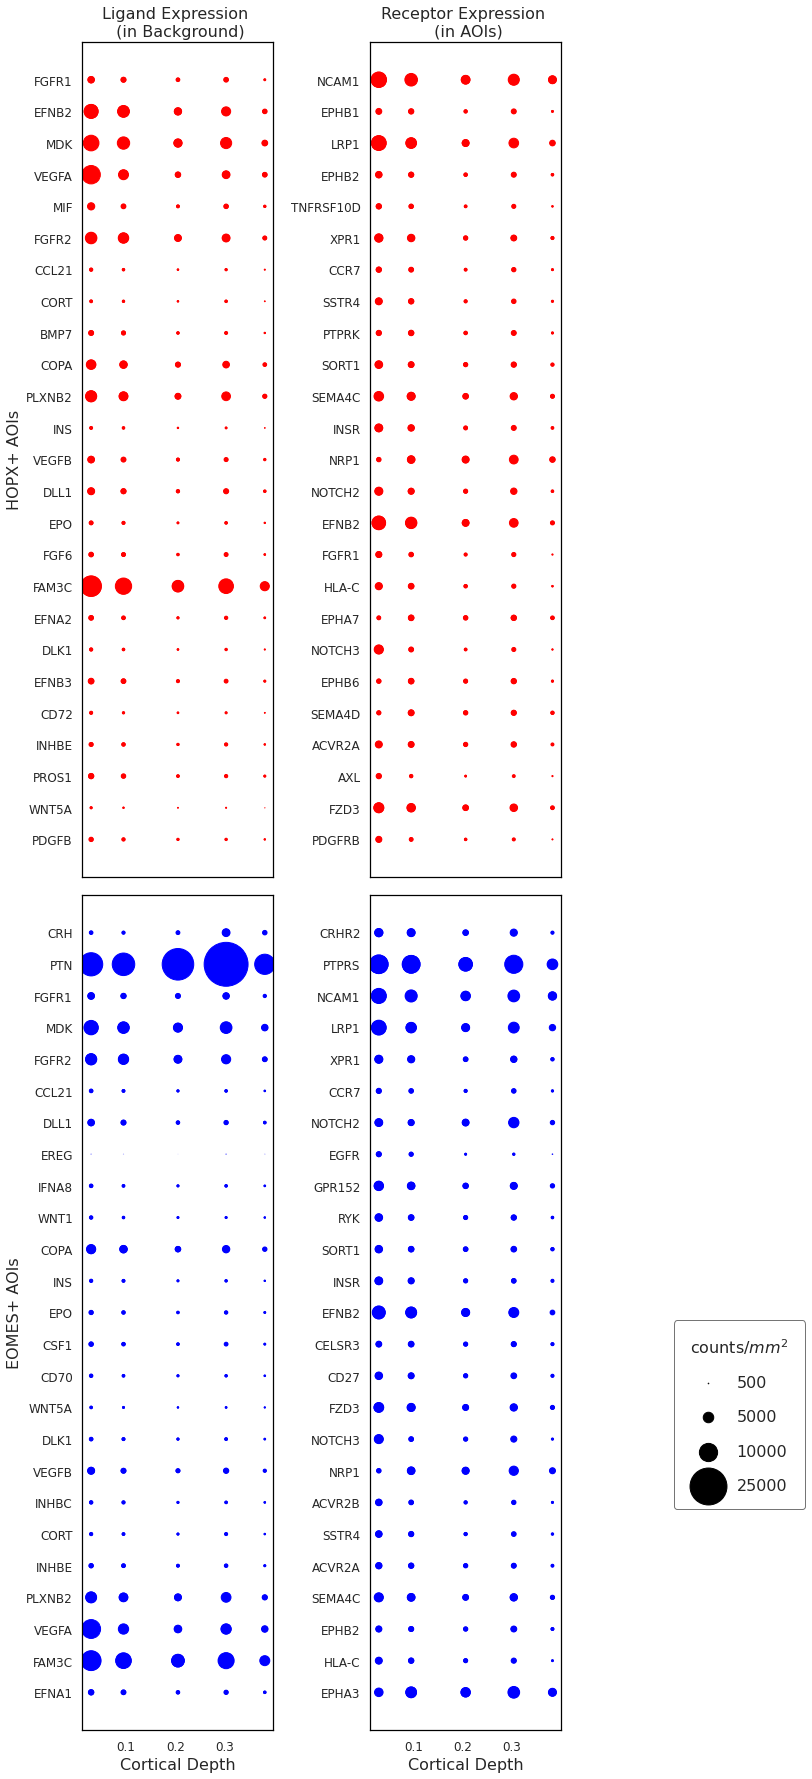

In [27]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 0.005
power = 1.5

fig, ax = plt.subplots(2,2,figsize = (10, 25), sharex = True)

# HOPXpos AOIs:
target_index = 0
nontarget_index = (1,0)[target_index]
normCounts_AOI = np.array([adata_AOIs[target_index].layers['X_Corrected_V2'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X_Corrected_V2'])[0])])*10**6

normCounts_Background = np.array([(adata_background.layers['X_Corrected_V2'][i,:] + adata_AOIs[nontarget_index].layers['X_Corrected_V2'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X_Corrected_V2'])[0])])*10**6

# Ligands:
genesForPlot = np.repeat(topLigands[0],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topLigands[0]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topLigands[0]])

ax[0,0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0,0].set_ylabel('HOPX+ AOIs')
ax[0,0].set_title('Ligand Expression \n (in Background)')
ax[0,0].set_facecolor('w')

# Receptors:
genesForPlot = np.repeat(topReceptors[0],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topReceptors[0]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topReceptors[0]])

ax[0,1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0,1].set_title('Receptor Expression \n (in AOIs)')
ax[0,1].set_facecolor('w')

# EOMESpos AOIs:
target_index = 1
nontarget_index = (1,0)[target_index]
normCounts_AOI = np.array([adata_AOIs[target_index].layers['X_Corrected_V2'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X_Corrected_V2'])[0])])*10**6

normCounts_Background = np.array([(adata_background.layers['X'][i,:] + adata_AOIs[nontarget_index].layers['X'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X'])[0])])*10**6

# Ligands:
genesForPlot = np.repeat(topLigands[1],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topLigands[1]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topLigands[1]])

ax[1,0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'blue')
ax[1,0].set_xlabel('Cortical Depth')
ax[1,0].set_ylabel('EOMES+ AOIs')
ax[1,0].set_facecolor('w')

# Receptors:
genesForPlot = np.repeat(topReceptors[1],np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(topReceptors[1]))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]] for j in topReceptors[1]])

ax[1,1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'blue')
ax[1,1].set_xlabel('Cortical Depth')
ax[1,1].set_facecolor('w')

# Make a legend:
pws = [0,500,5000,10000,25000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="counts/$mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/ReceptorLigand_UnbiasedSelection_areaNormalized_counts_top25Genes.pdf',
            bbox_inches='tight')

Finally plot ERBB4 ligands:

In [20]:
ERBB4_ligands = np.array(('HBEGF', 'NRG4', 'NRG2', 'EREG', 'BTC', 'NRG3', 'NRG1'))

In [21]:
adata.layers['norm_by_area'] = np.array([adata.layers['X'][i,:]/
                                                   adata.obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata.layers['X'])[0])])*10**6

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


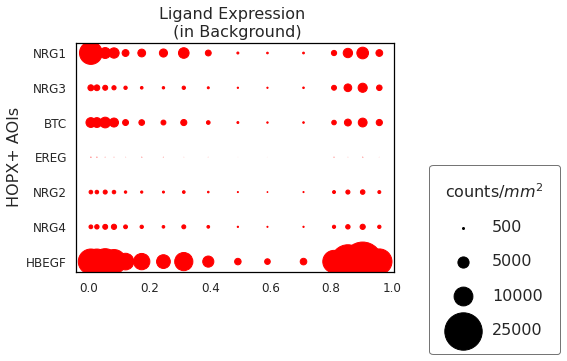

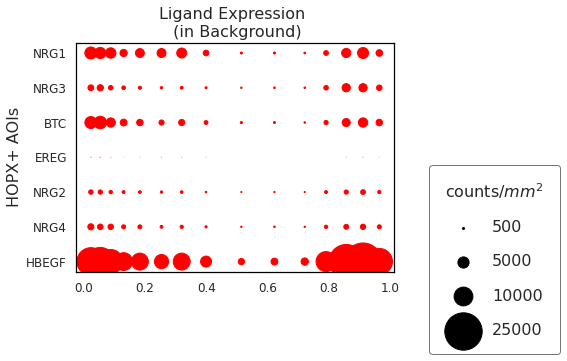

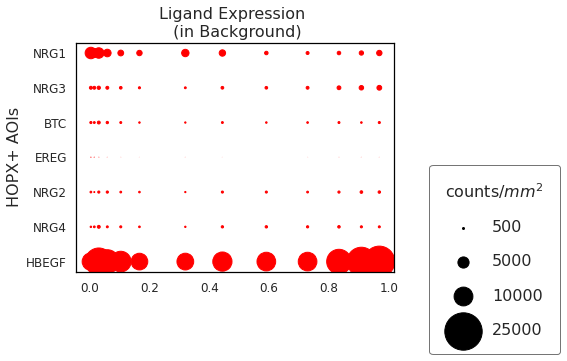

In [22]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)            # fontsize of the tick labels
plt.rc('ytick', labelsize=12)            # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 0.005
power = 1.5

labels = ('19pcw_1', '19pcw_2', '14pcw_1')
slides = np.array((('00MU'), ('00MV', '00MV-2'), ('00MW')))

for i in range(len(slides)):

    fig, ax = plt.subplots(1,1,figsize = (10, 5), sharex = True)
    
    normCounts_subset = [adata.obs['slide'].iloc[j] in slides[i]
                        and adata.obs['Radial_position'].iloc[j] == 2
                        for j in range(len(adata.obs['slide']))]
    
    normCounts = adata.layers['norm_by_area'][normCounts_subset,:]
    
    # Ligands:
    genesForPlot = np.repeat(ERBB4_ligands,np.shape(normCounts)[0])
    vcForPlot = np.array([adata.obs['VCDepth'].loc[normCounts_subset] for j in range(len(ERBB4_ligands))]).flatten()
    countsForPlot = np.array([normCounts[:,np.where(adata.var_names == j)[0][0]] for j in ERBB4_ligands])

    ax.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= 'red')
    ax.set_ylabel('HOPX+ AOIs')
    ax.set_title('Ligand Expression \n (in Background)')
    ax.set_facecolor('w')

    # Make a legend:
    pws = [0,500,5000,10000,25000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="counts/$mm^2$", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))

    plt.tight_layout()
    
    plt.savefig('ERBB4_ligandExpression_'+ labels[i] +'.pdf',
                bbox_inches='tight')